# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Data augmentation and normalization for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),  # Fixed size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train dataset with augmentation
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split trainset into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Validation dataset (using test transformations)
valset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
val_subset.dataset = valset  # Update transform for validation subset

# DataLoaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=4, shuffle=False, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


100%|██████████| 170498071/170498071 [00:01<00:00, 96214904.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


 deer  deer  frog horse


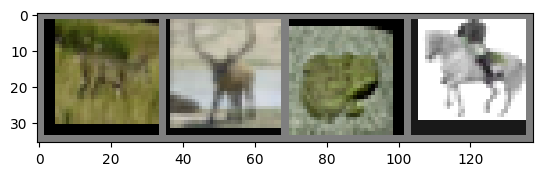

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5

  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(input channel, output channel, kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #마지막은 무조건 10으로 끝나게 해야 함.

    def forward(self, x):
      # CNN layer이다.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # FCN layer이다.
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = SimpleNet().to(device)

In [ ]:
!pip install torchsummary
from torchsummary import summary

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # Learning rate scheduling하는 거임. 이건 걍 step에 따라...

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
import matplotlib.pyplot as plt

# Set the number of epochs
epochs = 50

# Arrays to store training and validation losses
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    loss_tmp = 0.0
    epoch_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.item()
        epoch_loss += loss.item()

        if i % 5000 == 4999:  # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i + 1)))
            loss_tmp = 0.0

    # Calculate the average training loss for the epoch
    avg_train_loss = epoch_loss / (i + 1)
    train_losses.append(avg_train_loss)

    # Validation phase
    val_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(valloader)
    val_losses.append(avg_val_loss)

    # Update the learning rate according to the learning rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Train Loss: %.3f, Val Loss: %.3f' % (epoch + 1, avg_train_loss, avg_val_loss))

print('Finished Training')



[Epoch - 1, Iteration -  5000] Loss: 1.905
[Epoch - 1, Iteration - 10000] Loss: 0.839
[Epoch - 1] Train Loss: 1.791, Val Loss: 1.532
[Epoch - 2, Iteration -  5000] Loss: 1.585
[Epoch - 2, Iteration - 10000] Loss: 0.768
[Epoch - 2] Train Loss: 1.561, Val Loss: 1.347
[Epoch - 3, Iteration -  5000] Loss: 1.491
[Epoch - 3, Iteration - 10000] Loss: 0.727
[Epoch - 3] Train Loss: 1.473, Val Loss: 1.279
[Epoch - 4, Iteration -  5000] Loss: 1.421
[Epoch - 4, Iteration - 10000] Loss: 0.700
[Epoch - 4] Train Loss: 1.410, Val Loss: 1.256
[Epoch - 5, Iteration -  5000] Loss: 1.380
[Epoch - 5, Iteration - 10000] Loss: 0.689
[Epoch - 5] Train Loss: 1.379, Val Loss: 1.269
[Epoch - 6, Iteration -  5000] Loss: 1.370
[Epoch - 6, Iteration - 10000] Loss: 0.671
[Epoch - 6] Train Loss: 1.356, Val Loss: 1.300
[Epoch - 7, Iteration -  5000] Loss: 1.345
[Epoch - 7, Iteration - 10000] Loss: 0.666
[Epoch - 7] Train Loss: 1.339, Val Loss: 1.194
[Epoch - 8, Iteration -  5000] Loss: 1.323
[Epoch - 8, Iteration - 10

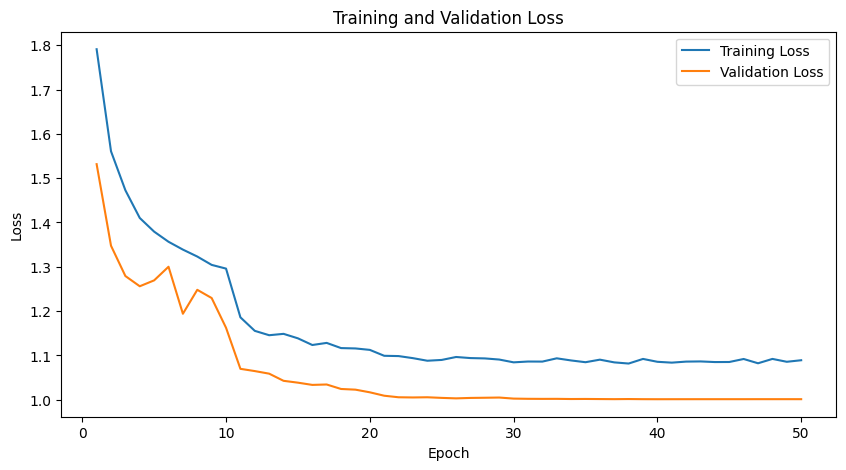

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


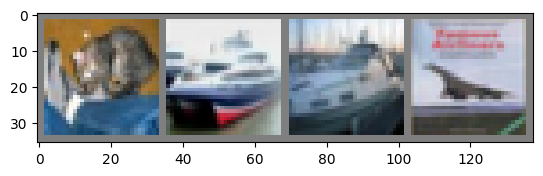

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10,000 test images: 65 %
